In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy

import vvnet
__import__("importlib").reload(vvnet)
from vvnet import VVNet, INPUT_SHAPE

2023-08-25 23:54:48.032847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def imshow(img):
    plt.axis('off')
    plt.imshow(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    plt.show()

Preprocessing data for the model

In [54]:
TIME_RANGE = INPUT_SHAPE[0]
FOLDER_PATH = "./DAVIS/{}/480p/{}"

def video_data_generator():
    for folder in os.listdir(FOLDER_PATH.format("Annotations", "")):

        if folder == ".DS_Store":
            continue

        # determine the frames in the video
        frames = os.listdir(FOLDER_PATH.format("Annotations", folder))
        if len(frames) < TIME_RANGE:
            continue

        # obtain data for each frame
        real_video, mask_video = [], []
        for step in frames[:32]:

            # get the real video
            real = cv2.imread(FOLDER_PATH.format("JPEGImages", f"{folder}/{step.replace('.png', '.jpg')}"))
            mask = cv2.imread(FOLDER_PATH.format("Annotations", f"{folder}/{step}"))

            # process the data
            real = cv2.resize(real, (128, 128))
            _, mask = cv2.threshold(cv2.resize(mask, (128, 128)), 150, 255, cv2.THRESH_BINARY)

            mask_video.append(mask / 255)
            real_video.append(real / 255) 
            
        yield np.array([real_video]), np.array([mask_video])

# debugging purposes
for video, mask in video_data_generator():
    pass

In [3]:
model = VVNet(vdepth=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 128, 128, 3)]    0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 128, 128, 64)     14144     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 128, 128, 64)     49280     ['sequential[0][0]']          
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 16, 64, 64, 64)       0         ['sequential_1[0][0]']        
 D)                                                                                           

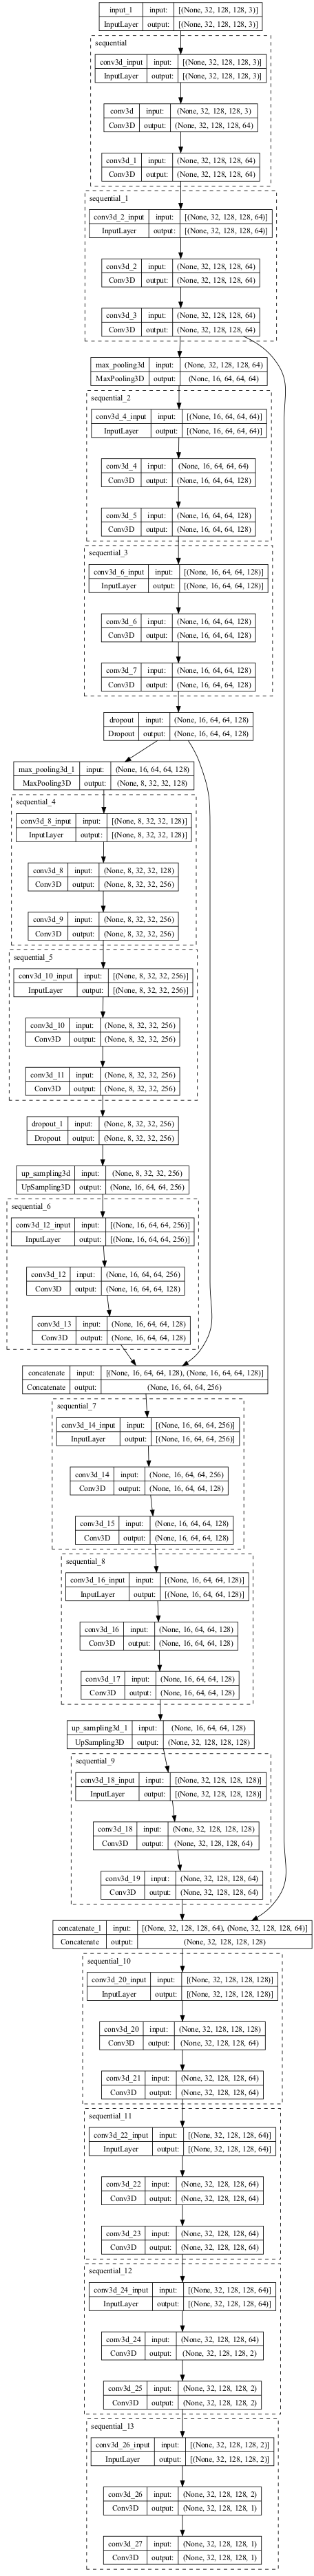

In [11]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

In [50]:
model.fit_generator(video_data_generator(), steps_per_epoch=8, epochs=5)

/var/folders/63/y2x5gxv51613j8s95jwnpddw0000gn/T/ipykernel_10166/4098747985.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(video_data_generator(), steps_per_epoch=8, epochs=5)


Epoch 1/5
8/8 [==============================] - 82s 10s/step - loss: 0.4278
Epoch 2/5
8/8 [==============================] - 79s 10s/step - loss: 0.1989
Epoch 3/5
8/8 [==============================] - 78s 10s/step - loss: 0.2167
Epoch 4/5
8/8 [==============================] - 79s 10s/step - loss: 0.2105
Epoch 5/5
8/8 [==============================] - 75s 9s/step - loss: 0.1950


In [ ]:
for video, _ in video_data_generator():
    mask = model.predict([video])

    example_vid = (video[0][16] * 255).astype(np.uint8)
    example_mask = (mask[0][16] * 255).astype(np.uint8)

    print(*mask[0][16])

    imshow(example_vid)
    imshow(example_mask)